# Purpose

The purpose of this notebook is to analyze text data related to the profiles of people charged in the FBI's [Operation Varsity Blues ](https://en.wikipedia.org/wiki/2019_college_admissions_bribery_scandal) probe. The data was taken from [here](https://deadspin.com/get-to-know-the-rich-assholes-charged-with-paying-milli-1833244052). The data analysis approach is an exploratory one and we will use visualization and unsupervised learning techniques to try and uncover some patterns.

In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np

with open('varsity-blues.json', 'r') as f:
    data = json.loads(f.read())

# Distributions

First, let's look at some distributions. Let's look at the gender and age distributions, in particular.

## Gender distribution

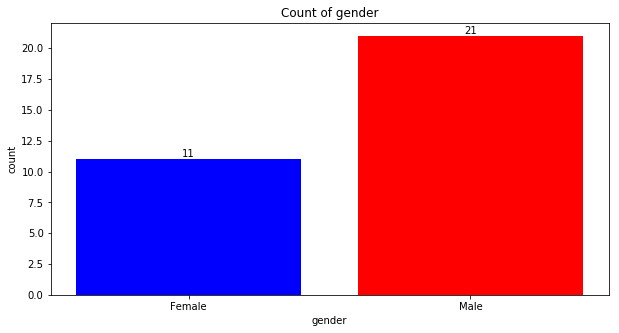

In [2]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')
        
genders = [individual['gender'] 
           for item in data 
           for individual in item['individual']]

num_females = sum(map(lambda g: 1 if g == 'F' else 0, genders))
num_males = sum(map(lambda g: 1 if g == 'M' else 0, genders))

gender_data = [num_females, num_males]
ind = np.arange(len(gender_data))
bars = ('Female', 'Male')

fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(ind, gender_data, color=['blue', 'red'])
ax.set_title('Count of gender')
ax.set_ylabel('count')
ax.set_xlabel('gender')
ax.set_xticks(ind)
ax.set_xticklabels(bars)
autolabel(rects)

As can be seen, nearly 2/3 of the people charged initially were males.

## Age distribution

min age = 48, max age = 86, average age = 56.94


Text(0.5, 0, 'age')

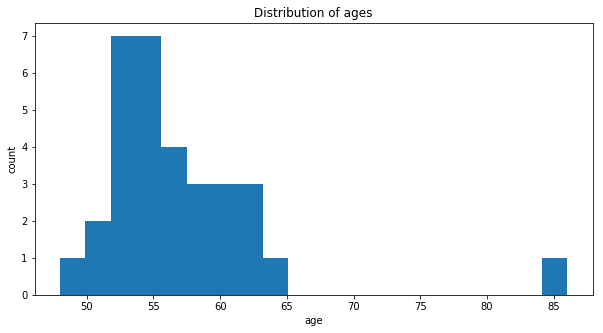

In [3]:
ages = [individual['age'] 
           for item in data 
           for individual in item['individual']]

min_age = min(ages)
max_age = max(ages)
avg_age = np.average(ages)

print('min age = {}, max age = {}, average age = {:.2f}'.format(
    min_age, max_age, avg_age))

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ages, bins=20)
ax.set_title('Distribution of ages')
ax.set_ylabel('count')
ax.set_xlabel('age')

The central tendency of age with the people charged in this case are around 55 years old. There is an outlier at 85 years.

## Age by gender distribution

Text(0.5, 1.0, 'Gender and age distribution')

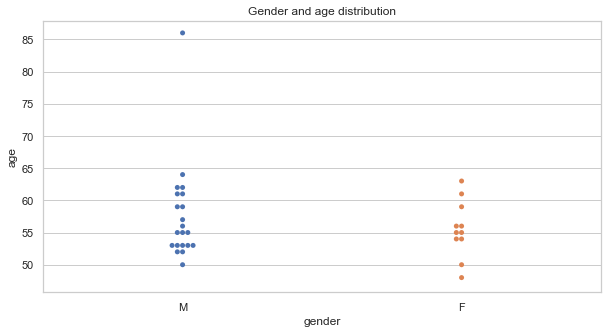

In [4]:
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

demographics = pd.DataFrame({'age': ages, 'gender': genders})

fig, ax = plt.subplots(figsize=(10, 5))
sns.swarmplot(x='gender', y='age', data=demographics, ax=ax)
ax.set_title('Gender and age distribution')

The swarm plot comparing age distribution by gender suggests that for the most part, most of the people charged are around 55 years old.

# Text analysis

Let's try to do some text analysis now. We have to first pre-process the text (tokenization, remove low frequency and stop words, and lemmatization). 

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.corpora.dictionary import Dictionary
from gensim import models

def get_profile(documents):
    frequency = {}
    for text in documents:
        tokens = [t.lower() for t in word_tokenize(text)]
        for word in tokens:
            if word not in frequency:
                frequency[word] = 0
            frequency[word] = frequency[word] + 1
    return frequency

def clean(text, profile, stop_words, stemmer):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if profile[word] > 1]
    tokens = [word for word in tokens if not word in stop_words]
    if stemmer is not None:
        tokens = [stemmer.stem(word) for word in tokens]
    tokens = [word for word in tokens if not word in stop_words]
    return tokens


first_names = [individual['first_name'].lower()
           for item in data 
           for individual in item['individual']]
last_names = [individual['last_name'].lower()
           for item in data 
           for individual in item['individual']]
names = []
names.extend(first_names)
names.extend(last_names)
names.extend(['bill'])
stop_words = stopwords.words('english')
stop_words.extend(['else', 'onto', 'said', 'someone', 'live', 
                   'designate', 'work', 'say', 'port', 'available',
                   'place', 'home', 'world', 'ye', 'yesterday', 'one',
                   'also', 'with', 'get', 'wit', 'way', 'marri', 'former',
                   'willki', 'phone', 'record', 'new', 'hundr', 'dollar',
                   'cooperating', 'document', 'quot', 'global', 'stock',
                   'lo', 'beach', 'senior', 'behalf', 'california', 'founder',
                   'page', 'san'
                  ])
stop_words.extend(names)

stemmer = PorterStemmer()

documents = [item['description'] for item in data]
profile = get_profile(documents)
texts = [clean(d, profile, stop_words, stemmer) for d in documents]
unstemmed_texts = [clean(d, profile, stop_words, None) for d in documents]

## Word distribution

Before we apply any fancy techniques, let's just observe the word distribution.

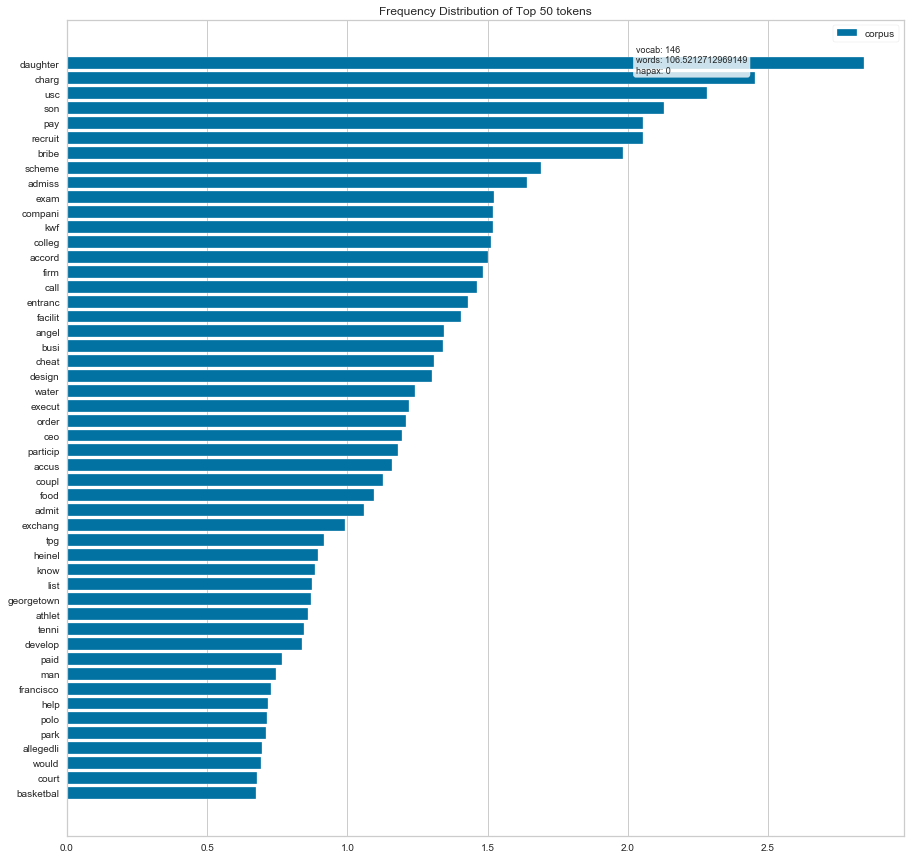

['accord', 'accus', 'act', 'actress', 'administr', 'admiss', 'admit', 'allegedli', 'angel', 'answer', 'applic', 'ask', 'athlet', 'basketbal', 'bloomberg', 'bribe', 'busi', 'call', 'capit', 'ceo', 'chairman', 'charg', 'cheat', 'citi', 'claim', 'class', 'coach', 'colleg', 'committe', 'compani', 'concern', 'conspiraci', 'correct', 'coupl', 'court', 'crew', 'daughter', 'dentistri', 'design', 'develop', 'diego', 'distilleri', 'distribut', 'donna', 'dragon', 'east', 'entranc', 'equiti', 'ernst', 'estat', 'exam', 'exchang', 'execut', 'facebook', 'facilit', 'fals', 'falsifi', 'farr', 'firm', 'food', 'found', 'foundat', 'francisco', 'fraud', 'fraudul', 'gallagh', 'georgetown', 'go', 'gordi', 'got', 'grade', 'growth', 'heinel', 'help', 'hercul', 'hyanni', 'intern', 'invest', 'investor', 'know', 'kwf', 'la', 'laguna', 'leav', 'like', 'linkedin', 'list', 'maci', 'mainten', 'man', 'manag', 'market', 'matter', 'menlo', 'miami', 'midwest', 'million', 'money', 'need', 'nevada', 'newport', 'okay', 'old

In [6]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

merged_text = [' '.join(text) for text in texts]

vectorizer = TfidfVectorizer()
docs       = vectorizer.fit_transform(merged_text)
features   = vectorizer.get_feature_names()

fig, ax = plt.subplots(figsize=(15, 15))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof(ax=ax)
print(features)

Note that the top 5 words are 

* daughter
* charge
* USC
* son
* California

The top 5 words are a good basic summary of Operation Varsity Blue: people in California where charged, concerning their sons and daughters, in something related to USC.

## Latent semantic indexing (LSI)

LSI will map the text data into latent or concept space (high-order meaning). Let's specify that there are 10 main concepts about the text we are dealing with and use LSI to flush out what those concepts might be.

In [7]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

num_topics = 10
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]

lsi.print_topics(num_topics)

[(0,
  '0.166*"water" + 0.156*"son" + 0.156*"angel" + 0.152*"exchang" + 0.147*"busi" + 0.143*"execut" + 0.141*"accord" + 0.141*"particip" + 0.138*"entranc" + 0.137*"admiss"'),
 (1,
  '-0.510*"busi" + -0.284*"publicli" + -0.202*"entranc" + -0.195*"park" + -0.193*"menlo" + -0.187*"particip" + -0.184*"exam" + -0.167*"colleg" + -0.153*"cheat" + -0.144*"food"'),
 (2,
  '0.490*"water" + 0.269*"polo" + 0.265*"tpg" + 0.176*"admit" + 0.164*"ask" + -0.158*"heinel" + -0.151*"food" + 0.146*"hyanni" + 0.141*"francisco" + -0.140*"busi"'),
 (3,
  '-0.245*"tenni" + -0.219*"angel" + 0.194*"develop" + 0.194*"admit" + 0.166*"hyanni" + -0.163*"unclear" + 0.159*"firm" + -0.154*"ernst" + -0.154*"coach" + -0.150*"vega"'),
 (4,
  '0.233*"basketbal" + 0.199*"heinel" + -0.194*"tenni" + -0.192*"maci" + -0.178*"univers" + -0.176*"coupl" + -0.175*"capit" + -0.168*"angel" + 0.149*"administr" + 0.149*"donna"'),
 (5,
  '-0.317*"exchang" + -0.315*"maci" + -0.303*"actress" + -0.295*"angel" + -0.204*"coupl" + -0.182*"cr

Looking at the topics above, we can't really tell what they are about. Can we? Let's try something different. Let's cluster the data points in concept (latent) space and try to flush out the concepts visually.

In [8]:
def scatter_plot_lsi(df, x1, x2):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(df[x1], df[x2])
    ax.set_title('{} vs {}'.format(x1, x2))
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    
    for i, name in enumerate(df['name']):
        x = df.iloc[i][x1]
        y = df.iloc[i][x2]
        ax.annotate(name, (x, y))
        
def lsi_to_df(corpus_lsi, data, num_topics):
    d = {}
    for i in range(num_topics):
        k = 'x{}'.format(i)
        v = [doc[i][1] for doc in corpus_lsi]
        d[k] = v
        i += 1
    d['name'] = [str(i) + '-' + item['individual'][0]['last_name'] for i, item in enumerate(data)]
    d['description'] = [item['description'] for item in data]
    return pd.DataFrame(d)

lsi_data = lsi_to_df(corpus_lsi, data, num_topics)

## Determine the number of clusters using silhouette score

We will use k-means to cluster the data points in concept space. First, though, we have to determine how many clusters we desire. We will choose k=2, ..., 20, and observe the Silhoutte scores. The number of clusters associated with the highest Silhouette score will be used to specify k for k-means.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def get_sil_avg(df, n_clusters):
    cols = [c for c in df.columns if c.startswith('x')]
    X = df[cols].values

    kmeans = KMeans(n_clusters=n_clusters, random_state=37).fit(X)
    labels = kmeans.fit_predict(X)

    sil_avg = silhouette_score(X, labels)
    return sil_avg

for n_clusters in range(2, 21, 1):
    sil_avg = get_sil_avg(lsi_data, n_clusters)
    print('{}: {:.5f}'.format(n_clusters, sil_avg))

2: 0.08381
3: 0.09557
4: 0.10993
5: 0.15568
6: 0.18296
7: 0.22174
8: 0.28046
9: 0.31355
10: 0.33734
11: 0.32490
12: 0.31812
13: 0.29998
14: 0.27132
15: 0.25786
16: 0.24932
17: 0.22705
18: 0.21617
19: 0.18844
20: 0.16941


It turns out that when k=10, the highest average Silhouette score is observed. So, we will use k=10. Note that choosing the number of concepts as 10 and k=10 is just a coincidence, as experimenting with a different number of concepts lead to a k that is usually not equal to such value.

## Clustering with k-means

Now, we can use k-means. Remember, we are clustering the data in concept (latent) space.

0 : 21 : 21-Chen
0 : 22 : 22-Klapper
1 : 13 : 13-Abdelaziz
1 : 19 : 19-Palatella
1 : 25 : 25-Zadeh
2 : 2 : 2-Hodge
2 : 4 : 4-Flaxman
2 : 6 : 6-Caplan
2 : 8 : 8-Zangrillo
3 : 0 : 0-McGlashan
3 : 1 : 1-Huneeus
4 : 10 : 10-Isackson
4 : 17 : 17-Janavs
4 : 18 : 18-MacFarlane
5 : 5 : 5-Buckingham
5 : 14 : 14-Blake
6 : 7 : 7-Abbott
6 : 20 : 20-Jan Sartorio
7 : 23 : 23-Sloane
7 : 24 : 24-Wilson
8 : 3 : 3-Henriquez
8 : 9 : 9-Semprevivo
8 : 16 : 16-Kimmel
9 : 11 : 11-Huffman
9 : 12 : 12-Giannulli
9 : 15 : 15-Colburn


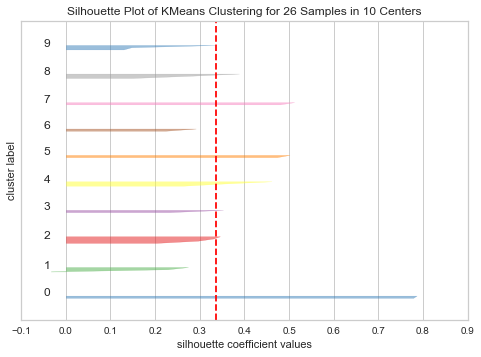

In [10]:
from yellowbrick.cluster import SilhouetteVisualizer

cols = [c for c in lsi_data.columns if c.startswith('x')]
X = lsi_data[cols].values

kmeans = KMeans(n_clusters=10, random_state=37).fit(X)
labels = kmeans.fit_predict(X)
tups = [(label, i, lsi_data.iloc[i]['name']) for i, label in enumerate(labels)]
tups = sorted(tups, key=lambda tup: tup[0])

for tup in tups:
    print('{} : {} : {}'.format(tup[0], tup[1], tup[2]))
    
# kmeans = KMeans(n_clusters=10, random_state=37)
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(X)
visualizer.poof()

The Silhouette plot above for k=10 shows that clusters 0, 2, and 9 may not really be good ones.

Look at cluster 3. Notice something there? Huffman and Loughlin (married to Giannulli) are both actresses.

## Visualizing clusters in concept (latent) space using parallel coordinates

Just for kicks, let's try to use parallel coordinates to visualize the clusters in concept space.

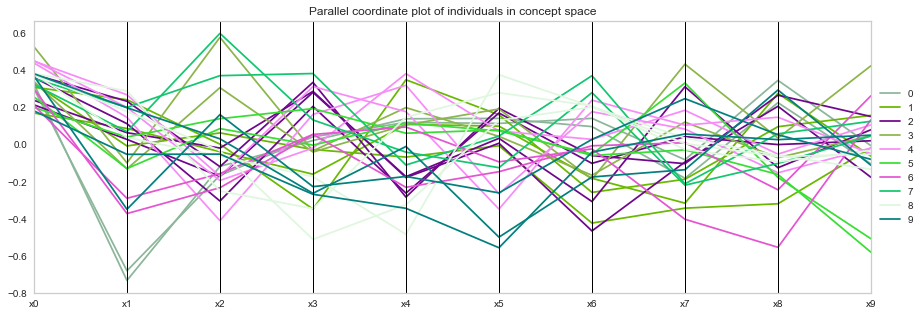

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
cols = [c for c in lsi_data.columns if c.startswith('x')]
lsi_df = lsi_data[cols].copy()
lsi_df['cluster'] = labels
lsi_df = lsi_df.sort_values(by=['cluster'])

pd.plotting.parallel_coordinates(lsi_df, 'cluster', ax=ax)
ax.set_title('Parallel coordinate plot of individuals in concept space')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We cannot really make sense of any patterns here either. But it looks beautiful and sophisticated.

## Visualizing clusters using word clouds

Let's just do something easy; let's use word clouds to visualize the words in each cluster.

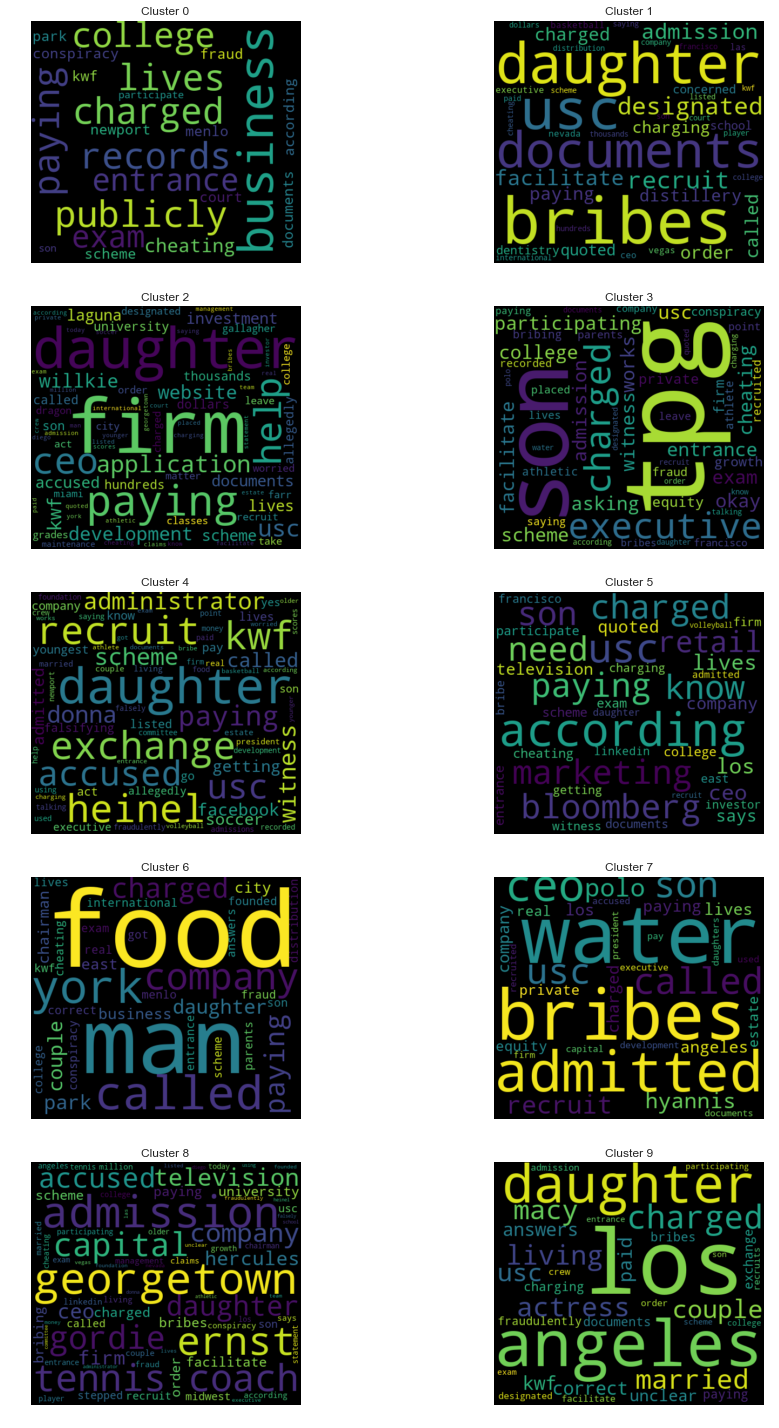

In [12]:
from wordcloud import WordCloud

def get_texts(cluster, texts, tups):
    cluster_tups = filter(lambda tup: tup[0] == cluster, tups)
    cluster_texts = map(lambda tup: texts[tup[1]], cluster_tups)
    cluster_texts = map(lambda arr: ' '.join(arr), cluster_texts)
    return ' '.join(cluster_texts)

fig, ax = plt.subplots(5, 2, figsize=(15, 20))
ax = np.ravel(ax)

for cluster in range(10):
    cluster_text = get_texts(cluster, unstemmed_texts, tups)
    wordcloud = WordCloud(width=500, height=450).generate(cluster_text)
    ax[cluster].imshow(wordcloud, interpolation='bilinear')
    ax[cluster].axis('off')
    ax[cluster].set_title('Cluster {}'.format(cluster))
plt.tight_layout()

Aha! 

* Cluster 0 is the "USC" cluster.
* Cluster 1 is the "food" cluster where many of the parents worked in that industry.
* Cluster 2 is the "TPG" cluster.
* Cluster 3 is the "actress" cluster. 
* Cluster 5 is the "water polo" cluster.
* Cluster 6 is the "Georgetown University" cluster; notice the word "tennis"?
* Cluster 8 is the "KWF" cluster.

Can we give snappy names for clusters 4, 7, and 9? 

## Exploring word embeddings

In [25]:
import gensim 
from gensim.models import Word2Vec 

emb_model = gensim.models.Word2Vec(texts, min_count = 3, size = 100, window = 30)

In [26]:
for word in ['bribe', 'usc', 'georgetown', 'tpg', 'kwf', 'coach', 'son', 'daughter', 'cheat', 'pay']:
    results = emb_model.wv.most_similar(positive=[word], topn=2)
    print('{}'.format(word))
    for result in results:
        print(' {}: {:.5f}'.format(result[0], result[1]))

bribe
 televis: 0.21215
 charg: 0.20544
usc
 accord: 0.30358
 capit: 0.23293
georgetown
 execut: 0.27176
 design: 0.25381
tpg
 act: 0.24866
 administr: 0.20976
kwf
 accord: 0.29404
 univers: 0.27751
coach
 daughter: 0.23710
 ceo: 0.23013
son
 scheme: 0.28589
 georgetown: 0.24572
daughter
 ernst: 0.29198
 soccer: 0.27154
cheat
 recruit: 0.21271
 real: 0.20962
pay
 court: 0.23982
 soccer: 0.22600


## Visualizing pairwise similarity in embedded space using a heatmap

In [15]:
import spacy

def get_pos_df(nlp, txt):
    tokens = nlp(txt)
    data = [(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop) for token in tokens]
    return pd.DataFrame(data, columns=['text', 'lemma', 'pos', 'tag', 'dep', 'shape', 'is_alpha', 'is_stop'])

def get_noun_phrases_df(nlp, txt):
    doc = nlp(txt)
    data = [(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text) for chunk in doc.noun_chunks]
    return pd.DataFrame(data, columns=['text', 'root_text', 'root_dep', 'root_head_text'])

def get_ner_df(nlp, txt):
    doc = nlp(txt)
    data = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    return pd.DataFrame(data, columns=['text', 'start_char', 'end_car', 'label'])

def get_sim_mat(docs, cols):
    n = len(docs)
    mat = np.zeros((n, n))
    for i in range(n):
        mat[i, i] = 1.0
        for j in range(i + 1, n, 1):
            sim = docs[i].similarity(docs[j])
            mat[i, j] = mat[j, i] = sim
    return pd.DataFrame(mat, index=cols, columns=cols)

nlp = spacy.load('en_core_web_lg')

Text(0.5, 1.0, 'Heatmap of textual similarities based on word embeddings')

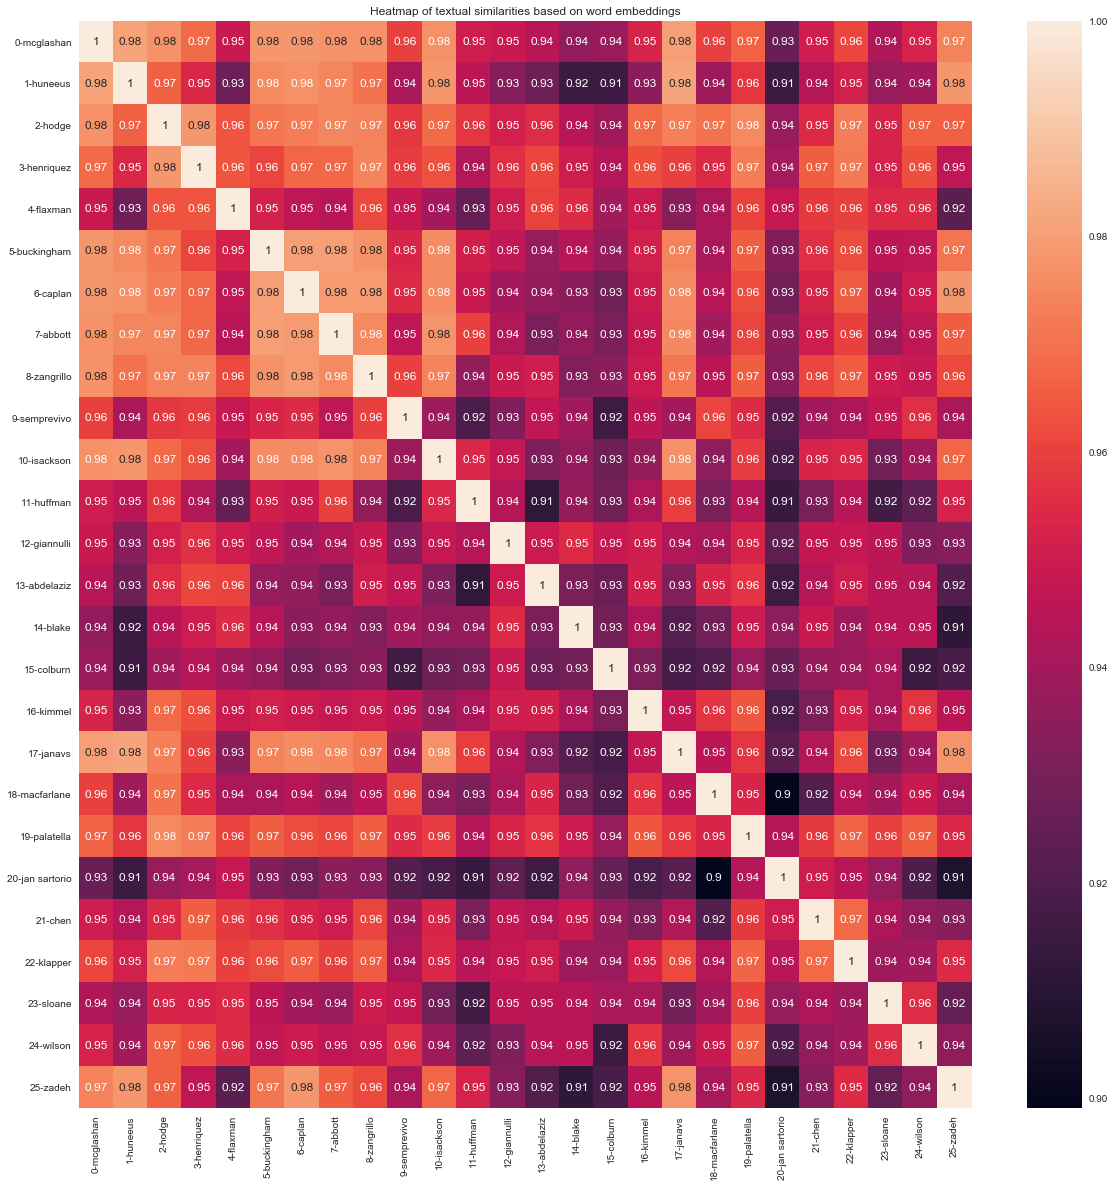

In [16]:
cols = [str(i) + '-' + item['individual'][0]['last_name'].lower() for i, item in enumerate(data)]
raw_text = [item['description'] for item in data]
nlp_docs = [nlp(text) for text in raw_text]

sim_mat = get_sim_mat(nlp_docs, cols)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(sim_mat, annot=True, ax=ax)
ax.set_title('Heatmap of textual similarities based on word embeddings')

# Visualizing distributions of different types of entitites

In [17]:
ner_df = pd.concat([get_ner_df(nlp, text) for text in raw_text]).reset_index(inplace=False)

Text(0.5, 1.0, 'Distribution of countries, cities, state')

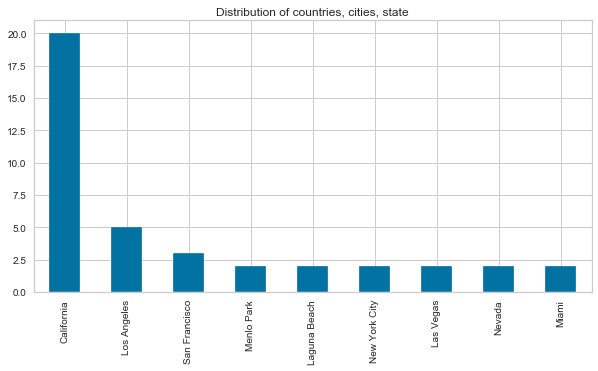

In [18]:
s = ner_df.query("label == 'GPE'")['text'].value_counts()
s = s[s > 1]
fig, ax = plt.subplots(figsize=(10, 5))
s.plot(kind='bar', ax=ax)
ax.set_title('Distribution of countries, cities, state')

Text(0.5, 1.0, 'Distribution of people')

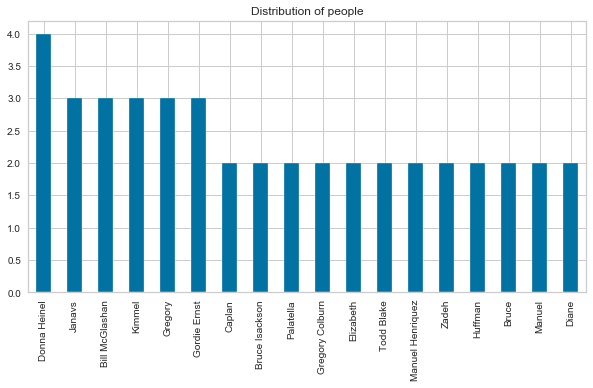

In [19]:
s = ner_df.query("label == 'PERSON'")['text'].value_counts()
s = s[s > 1]
s = s.drop(labels=['’m'])
fig, ax = plt.subplots(figsize=(10, 5))
s.plot(kind='bar', ax=ax)
ax.set_title('Distribution of people')

Text(0.5, 1.0, 'Distribution of companies, agencies, institutions, etc.')

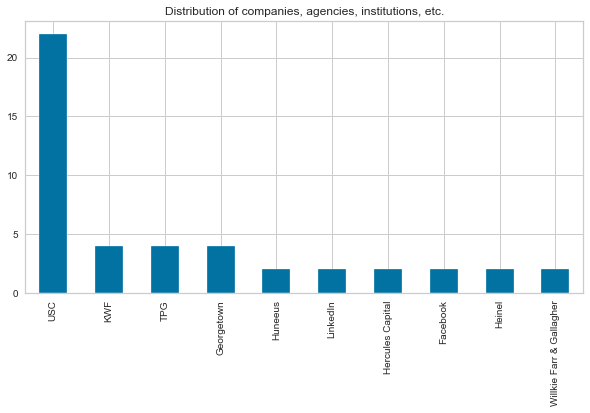

In [20]:
s = ner_df.query("label == 'ORG'")['text'].value_counts()
s = s[s > 1]
s = s.drop(labels=['’m'])
fig, ax = plt.subplots(figsize=(10, 5))
s.plot(kind='bar', ax=ax)
ax.set_title('Distribution of companies, agencies, institutions, etc.')

Text(0.5, 1.0, 'Distribution of monetary units')

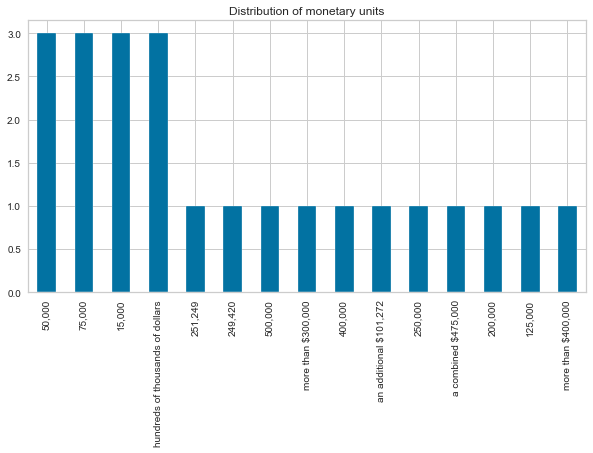

In [21]:
s = ner_df.query("label == 'MONEY'")['text'].value_counts()
drop_labels = [label for label in s.index if label.find('trillion') >= 0 or label.find('billion') >= 0 or label.find('million') >= 0]
s = s.drop(labels=drop_labels)
fig, ax = plt.subplots(figsize=(10, 5))
s.plot(kind='bar', ax=ax)
ax.set_title('Distribution of monetary units')

## Sentiment analysis

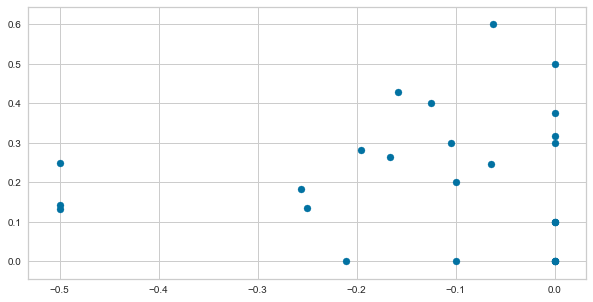

In [22]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

def get_neg_polarity(nlp, text):
    def rescale(polarities):
        sum_pol = sum(polarities)
        n = len(polarities)
        if n == 0:
            return 0.0
        return sum_pol / n
    
    doc = nlp(text)
    blobs = [TextBlob(sent.text).sentiment.polarity for sent in doc.sents]
    neg_polarities = list(filter(lambda p: p is not None and p < 0, blobs))
    pos_polarities = list(filter(lambda p: p is not None and p > 0, blobs))
    neg = rescale(neg_polarities)
    pos = rescale(pos_polarities)
    return neg, pos
    
polarity_df = pd.DataFrame([get_neg_polarity(nlp, text) for text in raw_text], columns=['neg', 'pos'])
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(polarity_df['neg'], polarity_df['pos'])

# References

* [Get To Know The Rich Assholes Charged With Paying Millions In Bribes To Get Their Kids Into College ](https://deadspin.com/get-to-know-the-rich-assholes-charged-with-paying-milli-1833244052)